In [1]:
import pandas as pd
from pathlib import Path
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import wilcoxon, ttest_ind, ranksums
from IPython.display import display
import numpy as np
sns.set(rc={'figure.figsize':(11.7,8.27)})


In [2]:
# This folder is generated after running evaluate_test_set.py in the 'evaluation' folder of the project
phantom_analysis_folder = Path('/home/suraj/Workspace/results/NKI/media_results/phantom_results').resolve()

In [3]:
small_phantom_df = []
big_phantom_df = []


for model in phantom_analysis_folder.iterdir():
    if not model.is_dir():
        continue
        
    small_phantom_path = model / "SmallConfig.csv"
    big_phantom_path = model / "BigConfig.csv"
    
    model_small_phantom_df = pd.read_csv(small_phantom_path, index_col=0)
    model_big_phantom_df = pd.read_csv(big_phantom_path, index_col=0)
    
    model_small_phantom_df = model_small_phantom_df.rename(columns={'0': model.stem})
    model_big_phantom_df = model_big_phantom_df.rename(columns={'0': model.stem})
    
    
    small_phantom_df.append(model_small_phantom_df)
    big_phantom_df.append(model_big_phantom_df)


In [7]:
def plot_insert_differences(phantom_df):
    phantom_values = {
            "Air": -1000,
            "LDPE": -100,
            "Polystyrene": -35,
            "Acrylic": 120,
            "Delrin": 340,
            "Teflon": 950,
            "Plate": 0
        }
    
    sns.set(font_scale=1.3) 

    # Rename models and filter indices to rename them with insert names
    phantom_df = phantom_df.rename(columns={"revvnet": "3D RevGAN", "3d_vnet": "3D CycleGAN", "baseline_2d": "2D CycleGAN", "ssim": "3D RevGAN + SSIM", "ssim_med_patch": "3D RevGAN + SSIM (24x224x224)", "ssim_small_patch": "3D RevGAN + SSIM (16x128x128)"})
    CBCT_differences = phantom_df.filter(like='CBCT_relative', axis=0)[['3D RevGAN']]
    sCT_differences = phantom_df.filter(like='sCT_relative', axis=0)
    CBCT_differences = CBCT_differences.rename(columns={"3D RevGAN": "Original"})
    insert_names = [val.replace('.sCT_relative_difference', '').replace('plate', 'Plate') for val in sCT_differences.index]
    
    sCT_differences = sCT_differences.set_axis(insert_names, axis=0)
    CBCT_differences = CBCT_differences.set_axis(insert_names, axis=0)
    print(sCT_differences)
    sCT_differences = sCT_differences.reindex(list(phantom_values.keys()))
    CBCT_differences = CBCT_differences.reindex(list(phantom_values.keys()))

    # Add original and ideal rows to the differences columns
    sCT_differences["Original"] = CBCT_differences["Original"]
    sCT_differences["Ideal"] = np.zeros(len(sCT_differences))
    sCT_differences = sCT_differences.drop("ssim_amp", axis=1)
    
    # Plot the figure
    f = plt.figure(figsize=(15, 8))
    sns.set(font_scale=1.8) 


    sns.set_style("ticks")


    plt.plot(sCT_differences["Original"], linewidth=1, marker='v', markersize=7, label="Original")
    plt.plot(sCT_differences["2D CycleGAN"], linewidth=1, marker='v', markersize=7, label="2D CycleGAN")
    plt.plot(sCT_differences["3D CycleGAN"], linewidth=1, marker='v', markersize=7, label="3D CycleGAN")
    plt.plot(sCT_differences["3D RevGAN"], linewidth=1, marker='v', markersize=7, label="3D RevGAN")
    plt.plot(sCT_differences["3D RevGAN + SSIM"], linewidth=1, marker='v', markersize=7, label="3D RevGAN + SSIM")

    plt.plot(sCT_differences[["Ideal"]],linestyle='dashed', color='black', label='Ideal')
    plt.yscale('symlog')
    plt.legend()
    plt.ylabel('Relative Difference from ideal value', fontsize=22)
    sns.despine(offset=10, trim=True)

    plt.show()

In [8]:
small_phantom = pd.concat(small_phantom_df, axis=1, sort=False)
big_phantom = pd.concat(big_phantom_df, axis=1, sort=False)

              3D RevGAN  3D RevGAN + SSIM (16x128x128)  2D CycleGAN  \
Polystyrene   -0.563312                      -0.417982     1.017345   
Acrylic        0.876460                      -5.590820    -5.095640   
Delrin         2.693331                      -0.805731    -3.537966   
Air          165.073242                     415.740560   443.976237   
Plate          2.305466                      -2.161635     0.005475   
Teflon         5.770997                      -4.389597    -4.697486   
LDPE           0.000000                      -0.182057     1.682196   

             3D RevGAN + SSIM  3D RevGAN + SSIM (24x224x224)    ssim_amp  \
Polystyrene         -4.778642                       4.308665    3.819826   
Acrylic             -2.036131                       0.186597    3.395729   
Delrin               3.122983                       2.341517    3.665747   
Air                 71.844076                     516.256510  241.477865   
Plate               -3.401954                      

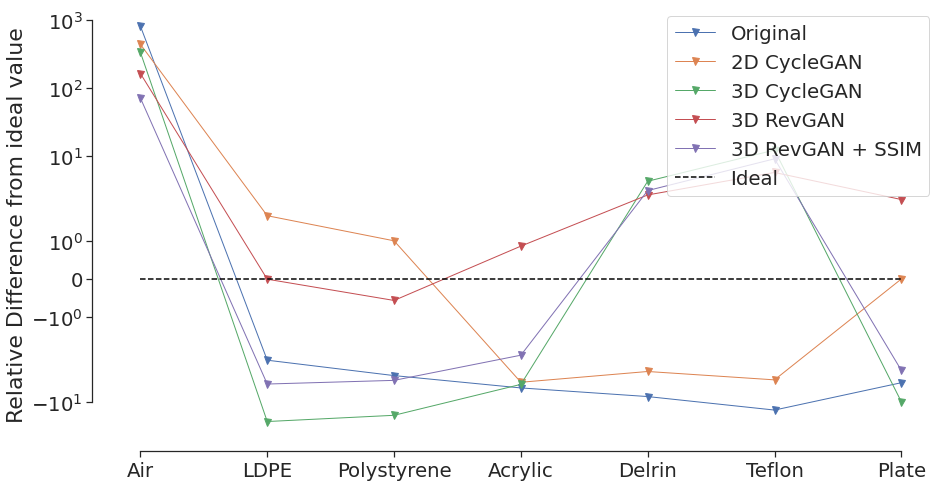

In [9]:
plot_insert_differences(small_phantom)

               3D RevGAN  3D RevGAN + SSIM (16x128x128)  2D CycleGAN  \
Polystyrene    -2.814777                      -2.368846    -3.952492   
Acrylic        -3.336575                      -7.161147    -6.800774   
Delrin         -6.342799                      -7.401714   -10.870908   
Air          1649.292118                     475.599845  1599.672665   
Plate          -3.706728                      -6.866102    -5.203154   
Teflon        -12.606111                     -21.797128   -18.725716   
LDPE            0.091050                       1.363543    -1.244334   

             3D RevGAN + SSIM  3D RevGAN + SSIM (24x224x224)     ssim_amp  \
Polystyrene         -2.968997                       0.362886     0.688422   
Acrylic             -5.007526                      -3.399114    -2.366960   
Delrin              -9.694534                      -9.202123    -7.862354   
Air               1713.398155                    1215.197691  1464.746195   
Plate               -2.825467         

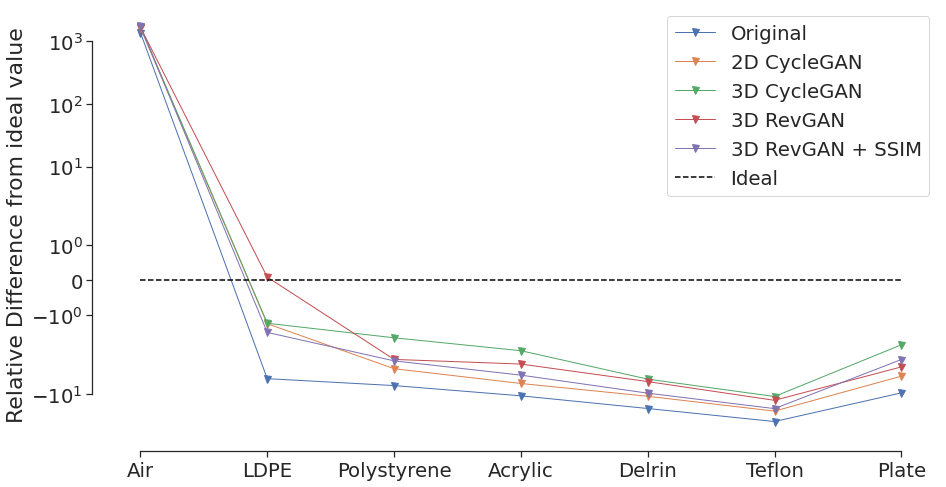

In [10]:
plot_insert_differences(big_phantom)